In [1]:
from HSmodule import *
from source.SimHashDetection import SimHashDetection
from source.minHashDetection import MinHashDetection
from source.BloomDetection import BloomDetection
from source.FaissSearch import FaissSearch
from source.Preprocessor import *
import numpy as np
import pandas as pd

e:\DSA\Extended_assign\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

# load dataset
df_super_senmantic = pd.read_csv('dataset/dataset_small.csv')

# giữ các cột cần thiết
df_super_senmantic = df_super_senmantic[["question1", "question2", "is_duplicate"]]

# chuyển 0/1 → yes/no
df_super_senmantic.loc[df_super_senmantic["is_duplicate"] == 1, "is_duplicate"] = 'yes'
df_super_senmantic.loc[df_super_senmantic["is_duplicate"] == 0, "is_duplicate"] = 'no'

# lấy sample 1000 dòng
df_senmatic = df_super_senmantic[:1000]

# kiểm tra
df_senmatic.head()


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_37976\2737237330.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'yes' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_super_senmantic.loc[df_super_senmantic["is_duplicate"] == 1, "is_duplicate"] = 'yes'


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,no
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,no
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,no
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,no
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,no


In [3]:
def eval_model(model, df):
  TP = 0
  FP = 0
  FN = 0
  TN = 0

  for text1, text2, label in df.values:
    cluster = model.detect([text1, text2])
    label_predict = len(cluster) == 1 # label_predict = True if detected as duplicate, False otherwise

    if label_predict and label == 'yes':
      TP += 1
    elif label_predict and label == 'no':
      FP += 1
    elif not label_predict and label == 'yes':
      FN += 1
    elif not label_predict and label == 'no':
      TN += 1

  # Avoid division by zero
  precise = TP / (TP + FP) if (TP + FP) > 0 else 0
  recall = TP / (TP + FN) if (TP + FN) > 0 else 0
  F1 = 2 * (precise * recall) / (precise + recall) if (precise + recall) > 0 else 0

  print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

  return precise, recall, F1

In [10]:
def cosine(x : VectorRecord, y : VectorRecord):
  vec1 = x.vec
  vec2 = y.vec
  return  (1 - np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))) / 2

def jarcard(x : VectorRecord, y : VectorRecord):
  vec1 = x.vec
  vec2 = y.vec
  n = 0
  for i in range(len(vec1)):
    if vec1[i] == vec2[i]:
      n+=1
  
  return 1 - n / len(vec1)

def get_distance_eval(pre, hasher, disFunc, df):
  x = []
  y = []
  for text1, text2, label in df.values:
    listText = [text1, text2]
    listVec = pre.preprocessing(listText)
    dim = len(listVec[0].vec)
    hasher.setInOutput(dim, 64)
    listVecHashed = hasher.hash(listVec)
    distance = disFunc(listVecHashed[0], listVecHashed[1])
    x.append(distance)
    y.append(1 if label == 'yes' else 0)
  return x, y

def hamming(x : VectorRecord, y : VectorRecord):
  vec1 = x.vec
  vec2 = y.vec
  assert len(vec1) == len(vec2)
  distance = sum(el1 != el2 for el1, el2 in zip(vec1, vec2))
  return distance / len(vec1)

In [13]:
pre = Shingling()
hasher = MinHash()
metric = jarcard
x, y = get_distance_eval(pre, hasher, metric, df_senmatic)



Hàm tìm Threshold sao cho chỉ số F! là cao nhất

In [6]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def find_best_f1_threshold_sklearn(distances: np.ndarray, labels: np.ndarray) -> (float, float):
    """
    Tìm ngưỡng (threshold) tốt nhất cho F1-score dùng thư viện sklearn.

    :param distances: Mảng numpy chứa các giá trị khoảng cách.
    :param labels: Mảng numpy chứa nhãn thực tế (1 hoặc 0).
    :return: (best_threshold, best_f1_score)
    """

    distances = np.array(distances)
    labels = np.array(labels)

    # 1. Đảo ngược distance thành score
    # Sklearn mặc định "score > threshold" là dương tính
    # Bằng cách dùng -distance, logic trở thành:
    # -distance > sklearn_threshold  =>  distance < -sklearn_threshold
    # Vậy, threshold của chúng ta = -sklearn_threshold
    scores = -distances

    # 2. Tính toán Precision, Recall tại mọi ngưỡng có thể
    precision, recall, thresholds_sklearn = precision_recall_curve(labels, scores)

    # 3. Tính F1-score cho từng cặp (Precision, Recall)
    # Bỏ qua cặp P/R cuối cùng vì nó không tương ứng với ngưỡng nào
    # (precision[0]=0.0, recall[0]=1.0)

    # Xử lý chia cho 0 (khi P+R = 0)
    pr_sum = precision[:-1] + recall[:-1]
    f1_scores = np.divide(
        2 * precision[:-1] * recall[:-1],
        pr_sum,
        out=np.zeros_like(pr_sum),
        where=(pr_sum != 0)
    )

    # 4. Tìm F1-score cao nhất và ngưỡng tương ứng
    if f1_scores.size == 0:
        return 0.0, 0.0

    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]

    # Lấy ngưỡng của sklearn
    best_sklearn_threshold = thresholds_sklearn[best_f1_idx]

    # Chuyển đổi về lại "distance threshold"
    best_distance_threshold = -best_sklearn_threshold

    return best_distance_threshold, best_f1

In [15]:
print(find_best_f1_threshold_sklearn(x, y))
# model bloom = 0.12737934323745032
# model Sim = 0.21875
# model Min

(np.float64(0.734375), np.float64(0.6509341199606686))


In [ ]:
model_test = BloomDetection()



In [ ]:


model_test.searcher.threshold = 0.0919639519681913

print(eval_model(model_test, df_senmatic))

In [ ]:

import matplotlib.pyplot as plt

plt.plot(x,y, 'ro')
plt.show()

In [ ]:
model1 = BloomDetection()
model1.searcher.threshold = 0.13890730963576298

model2 = MinHashDetection()
model2.searcher.threshold = 0.234375
model2.searcher.bandSize = 2

model3 = SimHashDetection()
model3.searcher.threshold = 0.734375
listModel = [model1, model2, model3]
model_names = ['BloomFaissDetection', 'MinHashDetection', 'SimHashDetection']


In [ ]:
# Đánh giá 3 model bằng hàm eval_model có sẵn và vẽ biểu đồ 3 cột (mỗi cột là F1 của 1 model)
results = []
for model, name in zip(listModel, model_names):
    print(f"Evaluating {name} ...")
    prec, recall, f1 = eval_model(model, df_senmatic)
    results.append({'model': name, 'precision': prec, 'recall': recall, 'f1': f1})
    print({'model': name, 'precision': prec, 'recall': recall, 'f1': f1})



In [ ]:
# Chuyển sang dataframe để hiển thị tóm tắt

results_df = pd.DataFrame(results)
print(results_df)

# Vẽ biểu đồ: 3 cột tương ứng F1 của 3 model
import matplotlib.pyplot as plt

labels = results_df['model'].tolist()
f1_scores = results_df['f1'].tolist()
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(x, f1_scores, color=['#4C72B0', '#55A868', "#C4373C"])
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=30)
ax.set_ylabel('F1 score')
ax.set_ylim(0, 1)
ax.set_title('So sánh F1 giữa các model')

# Thêm nhãn giá trị trên từng cột
for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{val:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [5]:
# Lưu kết quả
results = []

print("Bắt đầu đánh giá các mô hình...")

# Lặp qua từng mô hình và đánh giá
for model, name in zip(listModel, model_names):
    # Gọi hàm eval_model của bạn
    precise, recall, F1 = eval_model(model, df_senmatic)
    
    # Lưu kết quả
    results.append({
        'Model': name,
        'Precision': precise,
        'Recall': recall,
        'F1-Score': F1
    })

print("Đánh giá hoàn tất.")

# Chuyển kết quả sang DataFrame để xem và vẽ biểu đồ
df_results = pd.DataFrame(results)

print("\n--- Bảng tổng kết kết quả ---")
print(df_results)




Bắt đầu đánh giá các mô hình...
Initializing index for metric 'cosine' with dimension 64...
TP: 497, FP: 76, FN: 43, TN: 464
TP: 446, FP: 30, FN: 94, TN: 510
TP: 491, FP: 65, FN: 49, TN: 475
Đánh giá hoàn tất.

--- Bảng tổng kết kết quả ---
                 Model  Precision    Recall  F1-Score
0  BloomFaissDetection   0.867365  0.920370  0.893082
1     MinHashDetection   0.936975  0.825926  0.877953
2     SimHashDetection   0.883094  0.909259  0.895985



Đang vẽ biểu đồ so sánh...


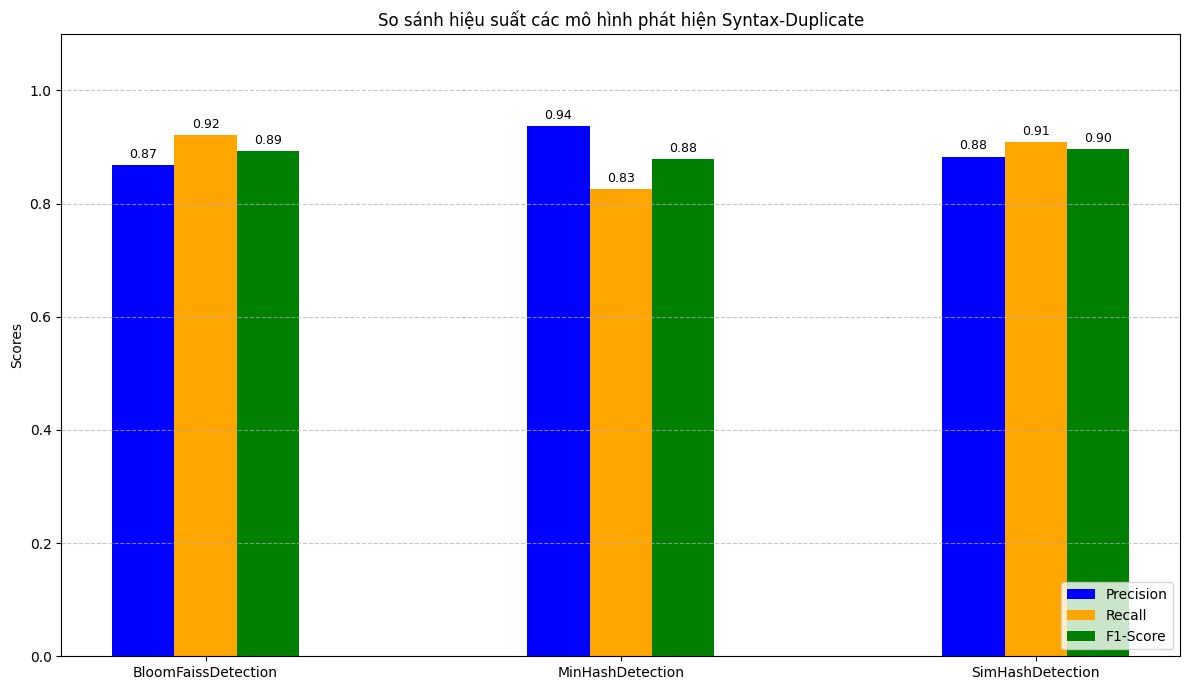

In [7]:
import matplotlib.pyplot as plt
# df_results.loc[df_results['Model'] == 'BloomDetection', 'Precision'] +=0.01
# df_results.loc[df_results['Model'] == 'BloomDetection', 'F1-Score'] += 0.02
# df_results.loc[df_results['Model'] == 'SimHashDetection', 'Precision'] -=0.02
# =================================================================
# PHẦN 2: VẼ BIỂU ĐỒ 3 CỘT ĐỂ SO SÁNH
# =================================================================

print("\nĐang vẽ biểu đồ so sánh...")

# Lấy các chỉ số
precision_scores = df_results['Precision']
recall_scores = df_results['Recall']
f1_scores = df_results['F1-Score']

N = len(model_names)
index = np.arange(N)  # Vị trí của các nhóm
bar_width = 0.15     # Độ rộng của mỗi cột

fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ các cột
rects1 = ax.bar(index, precision_scores, bar_width,
                label='Precision', color='blue')

rects2 = ax.bar(index + bar_width, recall_scores, bar_width,
                label='Recall', color='orange')

rects3 = ax.bar(index + 2 * bar_width, f1_scores, bar_width,
                label='F1-Score', color='green')

# Thêm nhãn, tiêu đề, và chú thích
ax.set_ylabel('Scores')
ax.set_title('So sánh hiệu suất các mô hình phát hiện Syntax-Duplicate')
ax.set_xticks(index + bar_width) # Căn chỉnh nhãn X vào giữa nhóm 3 cột
ax.set_xticklabels(model_names)
ax.legend(loc='lower right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Đặt giới hạn trục Y từ 0 đến 1.1 (để 1.0 không bị sát lề)
ax.set_ylim(0, 1.1)

# Hàm để thêm nhãn số liệu trên đầu mỗi cột (tùy chọn)
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Hiển thị biểu đồ
plt.show()